<a href="https://colab.research.google.com/github/Tahsinoshin/Urban_planning_GAN-SPL3/blob/main/ReImagining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
Mounting google drive
```



In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/UrbanPlan2021

/content/drive/MyDrive/UrbanPlan2021


Running Create suitable data


In [3]:
import numpy as np
import pandas as pd
from collections import defaultdict

poi_dis = np.load("data/data/100_poi_dis.npz")["arr_0"]
func_zone1 = np.load("data/data/func1_100.npz")["arr_0"]
#func_zone2 = np.load("data/data/func2_100.npz")["arr_0"]
env_rep = np.load("data/env_embedding1.npz")["arr_0"]
house_sit = pd.read_excel("data/house_situation.xlsx")

# classify the green level of different residential community.
house_green = house_sit["绿化率"]
house_green = house_green.reset_index()
house_green['绿化率'] = house_green['绿化率'].replace("暂无资料",0)
house_green["绿化率"] = house_green['绿化率'].astype(float)
print("green level max value:",house_green['绿化率'].max())
print("green level max value:",house_green['绿化率'].min())
house_green["green_level"] = pd.cut(house_green['绿化率'],5,labels=[0,1,2,3,4])
green_emb = pd.get_dummies(house_green["green_level"]).values
np.savez_compressed("data/data/green_level_emb.npz",green_emb)
print("The green level distribution of all communities as follows: ",house_green.groupby('green_level')['index'].count())


green level max value: 0.95
green level max value: 0.0
The green level distribution of all communities as follows:  green_level
0     598
1    1818
2     447
3      98
4      29
Name: index, dtype: int64


Running LUCGAN model


In [ ]:
import sys
sys.path.append(".")
import numpy as np
from tensorflow.keras import layers
import time
import tensorflow as tf

def read_data():
    env_rep = np.load("data/env_embedding1.npz")["arr_0"]
    green_emb = np.load("data/data/green_level_emb.npz")["arr_0"]
    con_emb = np.hstack([env_rep,green_emb])
    urban_sol = np.load("data/data/10_poi_dis.npz")["arr_0"]
    func_zone = np.load("data/data/func1_10.npz")["arr_0"]
    urban_sol = urban_sol.reshape((urban_sol.shape[0],-1))
    func_zone = func_zone.reshape((func_zone.shape[0],-1))
    return urban_sol, func_zone, con_emb

def generate_data_batch(urban_sol,func_zone,con_emb,batch_size,ratio):
    data_len = urban_sol.shape[0]
    urban_sol = tf.data.Dataset.from_tensor_slices(urban_sol)
    func_zone = tf.data.Dataset.from_tensor_slices(func_zone)
    con_emb = tf.data.Dataset.from_tensor_slices(con_emb)

    train_sol, test_sol = urban_sol.take(int(data_len*ratio)),urban_sol.skip(int(data_len*ratio))
    train_func, test_func = func_zone.take(int(data_len*ratio)),func_zone.skip(int(data_len*ratio))
    train_con, test_con = con_emb.take(int(data_len*ratio)),con_emb.skip(int(data_len*ratio))

    con_label = []
    for test_sample in test_con:
        con_label.append(np.argmax(test_sample.numpy()[-5:]))
    con_label = np.array(con_label)
    np.savez_compressed("data/data/con_label.npz",con_label)

    train_sol = train_sol.batch(batch_size=batch_size)
    train_func = train_func.batch(batch_size=batch_size)
    train_con = train_con.batch(batch_size=batch_size)

    test_sol = test_sol.batch(batch_size=batch_size)
    test_func = test_func.batch(batch_size=batch_size)
    test_con = test_con.batch(batch_size=batch_size)

    train_dataset = tf.data.Dataset.zip((train_sol,train_func,train_con))
    test_dataset = tf.data.Dataset.zip((test_sol, test_func, test_con))

    return train_dataset,test_dataset

#设计生成器generator
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(5*5*256, use_bias=False, input_shape=(10,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((5, 5, 256)))


    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (7, 7), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(20, (7, 7), strides=(1, 1), padding='same', use_bias=False,activation="tanh"))

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[10, 10, 20]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

#最大化优秀的规划方案的loss，对于差的规划方案和generated的规划方案都要减小
def discriminator_loss(good_output, fake_output,bad_output):
    good_loss = cross_entropy(tf.ones_like(good_output), good_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    bad_loss = cross_entropy(tf.zeros_like(bad_output), bad_output)
    total_loss = good_loss + fake_loss + bad_loss
    return total_loss

#要让生成器生成的结果越优秀越好
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def train_step(good_plan,bad_plan,context_feature):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_plan = generator(context_feature, training=True)

      good_output = discriminator(good_plan, training=True)
      fake_output = discriminator(generated_plan, training=True)
      bad_output = discriminator(bad_plan, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(good_output, fake_output, bad_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

urban_sol,func_zone, con_emb = read_data()
train_dataset, test_dataset = generate_data_batch(urban_sol,func_zone,con_emb, 4 , 0.9)

#测试generator能否生成对应shape的规划方案
generator = make_generator_model()
#测试对应的discriminator的作用
discriminator = make_discriminator_model()

# cross_entropy损失为了后续的正负类的分类任务。
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#定义generator和discriminator的优化器
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#training phase
for epoch in range(1, 50 + 1):
  start_time = time.time()
  for batch_ind, data in enumerate(train_dataset):
      batch_urban = tf.reshape(data[0], (-1, 10, 10, 20))
      batch_env = data[2][:, :-5]
      bad_urban = tf.random.shuffle(batch_urban)
      train_step(batch_urban,bad_urban,batch_env)
  end_time = time.time()
  print('Epoch: {}, time elapse for current epoch: {}'
        .format(epoch, end_time - start_time))

result = []
for data in test_dataset:
    test_con = data[2][:,:-5]
    generated_sol = generator(test_con)
    result.append(np.maximum(generated_sol.numpy(),0.00001))

generate_us = result[0]
for i in range(1,len(result)):
    generate_us = np.vstack((generate_us,result[i]))
generate_us = generate_us.reshape((generate_us.shape[0], 10, 10, 20))
np.savez_compressed("../tmp/10_lucgan_generate_result.npz", generate_us)
print("LUCGAN model is ended!")





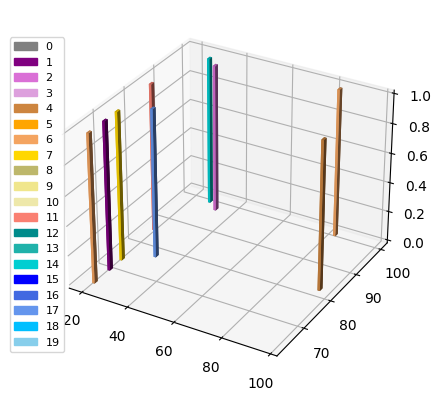

In [ ]:
import numpy as np
import pickle
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import axes3d
from matplotlib.backends.backend_pdf import PdfPages

poi = np.load('./data/data/100_poi_dis.npz', encoding='latin1')
poi = poi['arr_0'][-299:]
# poi = np.load('./model/tmp/cluvae_generate_result_50.npz', encoding='latin1')
poi_data = poi.reshape(299,1,100,100,20)
poi_data = poi_data

n = 9
data0 = poi_data[n][0][:, :, 0]
data1 = poi_data[n][0][:, :, 1]
data2 = poi_data[n][0][:, :, 2]
data3 = poi_data[n][0][:, :, 3]
data4 = poi_data[n][0][:, :, 4]
data5 = poi_data[n][0][:, :, 5]
data6 = poi_data[n][0][:, :, 6]
data7 = poi_data[n][0][:, :, 7]
data8 = poi_data[n][0][:, :, 8]
data9 = poi_data[n][0][:, :, 9]
data10 = poi_data[n][0][:, :, 10]
data11 = poi_data[n][0][:, :, 11]
data12 = poi_data[n][0][:, :, 12]
data13 = poi_data[n][0][:, :, 13]
data14 = poi_data[n][0][:, :, 14]
data15 = poi_data[n][0][:, :, 15]
data16 = poi_data[n][0][:, :, 16]
data17 = poi_data[n][0][:, :, 17]
data18 = poi_data[n][0][:, :, 18]
data19 = poi_data[n][0][:, :, 19]
# data0 = poi['arr_0'][n][0, :, :]
# data1 = poi['arr_0'][n][1, :, :]
# data2 = poi['arr_0'][n][2, :, :]
# data3 = poi['arr_0'][n][3, :, :]
# data4 = poi['arr_0'][n][4, :, :]
# data5 = poi['arr_0'][n][5, :, :]
# data6 = poi['arr_0'][n][6, :, :]
# data7 = poi['arr_0'][n][7, :, :]
# data8 = poi['arr_0'][n][8, :, :]
# data9 = poi['arr_0'][n][9, :, :]
# data10 = poi['arr_0'][n][10, :, :]
# data11 = poi['arr_0'][n][11, :, :]
# data12 = poi['arr_0'][n][12, :, :]
# data13 = poi['arr_0'][n][13, :, :]
# data14 = poi['arr_0'][n][14, :, :]
# data15 = poi['arr_0'][n][15, :, :]
# data16 = poi['arr_0'][n][16, :, :]
# data17 = poi['arr_0'][n][17, :, :]
# data18 = poi['arr_0'][n][18, :, :]
# data19 = poi['arr_0'][n][19, :, :]

# set the grid parameter
def gen_pos(data):
    grid = 100
    x = []
    y = []
    z = []
    i = 0
    while i<grid:
        j = 0
        while j<grid:
            if data[i][j] > 0.0:
                x.append(i)
                y.append(j)
                z.append(data[i][j])
            j += 1
        i += 1
    return x, y, z

x0, y0, z0 = gen_pos(data0)
x1, y1, z1 = gen_pos(data1)
x2, y2, z2 = gen_pos(data2)
x3, y3, z3 = gen_pos(data3)
x4, y4, z4 = gen_pos(data4)
x5, y5, z5 = gen_pos(data5)
x6, y6, z6 = gen_pos(data6)
x7, y7, z7 = gen_pos(data7)
x8, y8, z8 = gen_pos(data8)
x9, y9, z9 = gen_pos(data9)
x10, y10, z10 = gen_pos(data10)
x11, y11, z11 = gen_pos(data11)
x12, y12, z12 = gen_pos(data12)
x13, y13, z13 = gen_pos(data13)
x14, y14, z14 = gen_pos(data14)
x15, y15, z15 = gen_pos(data15)
x16, y16, z16 = gen_pos(data16)
x17, y17, z17 = gen_pos(data17)
x18, y18, z18 = gen_pos(data18)
x19, y19, z19 = gen_pos(data19)

fig = plt.figure()
ax = pl.subplot(projection='3d')

# color_codes = ['b', 'g', 'r', 'c', 'm', 'y', 'blue', 'orange', 'green', 'coral', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'peru', 'tan', 'skyblue', 'orchid']
color_codes = ['gray', 'purple', 'orchid', 'plum', 'peru', 'orange', 'sandybrown', 'gold', 'darkkhaki', 'khaki', 'palegoldenrod', 'salmon', 'darkcyan', 'lightseagreen', 'darkturquoise', 'blue', 'royalblue', 'cornflowerblue', 'deepskyblue', 'skyblue']
# x_pos = x1
# y_pos = y1
# z_pos = np.zeros(len(z1))

# x_size = np.ones(len(x1))
# y_size = np.ones(len(y1))
# z_height = z1

trans = 1
try:
    ax.bar3d(x0, y0, np.zeros(len(z0)), np.ones(len(x0)), np.ones(len(y0)), z0, color=color_codes[0], alpha=trans)
except ValueError:  #raised if `x, y, z` is empty.
    pass
try:
    ax.bar3d(x1, y1, np.zeros(len(z1)), np.ones(len(x1)), np.ones(len(y1)), z1, color=color_codes[1], alpha=trans)
except ValueError:  #raised if `x, y, z` is empty.
    pass
try:
    channel2 = ax.bar3d(x2, y2, np.zeros(len(z2)), np.ones(len(x2)), np.ones(len(y2)), z2, color=color_codes[2], alpha=trans)
except ValueError:  #raised if `x, y, z` is empty.
    pass
try:
    channel3 = ax.bar3d(x3, y3, np.zeros(len(z3)), np.ones(len(x3)), np.ones(len(y3)), z3, color=color_codes[3], alpha=trans)
except ValueError:  #raised if `x, y, z` is empty.
    pass
try:
    channel4 = ax.bar3d(x4, y4, np.zeros(len(z4)), np.ones(len(x4)), np.ones(len(y4)), z4, color=color_codes[4], alpha=trans)
except ValueError:  #raised if `x, y, z` is empty.
    pass
try:
    channel5 = ax.bar3d(x5, y5, np.zeros(len(z5)), np.ones(len(x5)), np.ones(len(y5)), z5, color=color_codes[5], alpha=trans)
except ValueError:  #raised if `x, y, z` is empty.
    pass
try:
    channel6 = ax.bar3d(x6, y6, np.zeros(len(z6)), np.ones(len(x6)), np.ones(len(y6)), z6, color=color_codes[6], alpha=trans)
except ValueError:  #raised if `x, y, z` is empty.
    pass
try:
    channel7 = ax.bar3d(x7, y7, np.zeros(len(z7)), np.ones(len(x7)), np.ones(len(y7)), z7, color=color_codes[7], alpha=trans)
except ValueError:  #raised if `x, y, z` is empty.
    pass
try:
    channel8 = ax.bar3d(x8, y8, np.zeros(len(z8)), np.ones(len(x8)), np.ones(len(y8)), z8, color=color_codes[8], alpha=trans)
except ValueError:  #raised if `x, y, z` is empty.
    pass
try:
    channel9 = ax.bar3d(x9, y9, np.zeros(len(z9)), np.ones(len(x9)), np.ones(len(y9)), z9, color=color_codes[9], alpha=trans)
except ValueError:  #raised if `x, y, z` is empty.
    pass
try:
    channel10 = ax.bar3d(x10, y10, np.zeros(len(z10)), np.ones(len(x10)), np.ones(len(y10)), z10, color=color_codes[10], alpha=trans)
except ValueError:  #raised if `x, y, z` is empty.
    pass
try:
    channel11 = ax.bar3d(x11, y11, np.zeros(len(z11)), np.ones(len(x11)), np.ones(len(y11)), z11, color=color_codes[11], alpha=trans)
except ValueError:  #raised if `x, y, z` is empty.
    pass
try:
    channel12 = ax.bar3d(x12, y12, np.zeros(len(z12)), np.ones(len(x12)), np.ones(len(y12)), z12, color=color_codes[12], alpha=trans)
except ValueError:  #raised if `x, y, z` is empty.
    pass
try:
    channel13 = ax.bar3d(x13, y13, np.zeros(len(z13)), np.ones(len(x13)), np.ones(len(y13)), z13, color=color_codes[13], alpha=trans)
except ValueError:  #raised if `x, y, z` is empty.
    pass
try:
    channel14 = ax.bar3d(x14, y14, np.zeros(len(z14)), np.ones(len(x14)), np.ones(len(y14)), z14, color=color_codes[14], alpha=trans)
except ValueError:  #raised if `x, y, z` is empty.
    pass
try:
    channel15 = ax.bar3d(x15, y15, np.zeros(len(z15)), np.ones(len(x15)), np.ones(len(y15)), z15, color=color_codes[15], alpha=trans)
except ValueError:  #raised if `x, y, z` is empty.
    pass
try:
    channel16 = ax.bar3d(x16, y16, np.zeros(len(z16)), np.ones(len(x16)), np.ones(len(y16)), z16, color=color_codes[16], alpha=trans)
except ValueError:  #raised if `x, y, z` is empty.
    pass
try:
    channel17 = ax.bar3d(x17, y17, np.zeros(len(z17)), np.ones(len(x17)), np.ones(len(y17)), z17, color=color_codes[17], alpha=trans)
except ValueError:  #raised if `x, y, z` is empty.
    pass
try:
    channel18 = ax.bar3d(x18, y18, np.zeros(len(z18)), np.ones(len(x18)), np.ones(len(y18)), z18, color=color_codes[18], alpha=trans)
except ValueError:  #raised if `x, y, z` is empty.
    pass
try:
    ax.bar3d(x19, y19, np.zeros(len(z19)), np.ones(len(x19)), np.ones(len(y19)), z19, color=color_codes[19], alpha=trans)
except ValueError:  #raised if `x, y, z` is empty.
    pass
channel0 = mpatches.Patch(color=color_codes[0], label='0')
channel1 = mpatches.Patch(color=color_codes[1], label='1')
channel2 = mpatches.Patch(color=color_codes[2], label='2')
channel3 = mpatches.Patch(color=color_codes[3], label='3')
channel4 = mpatches.Patch(color=color_codes[4], label='4')
channel5 = mpatches.Patch(color=color_codes[5], label='5')
channel6 = mpatches.Patch(color=color_codes[6], label='6')
channel7 = mpatches.Patch(color=color_codes[7], label='7')
channel8 = mpatches.Patch(color=color_codes[8], label='8')
channel9 = mpatches.Patch(color=color_codes[9], label='9')
channel10 = mpatches.Patch(color=color_codes[10], label='10')
channel11 = mpatches.Patch(color=color_codes[11], label='11')
channel12 = mpatches.Patch(color=color_codes[12], label='12')
channel13 = mpatches.Patch(color=color_codes[13], label='13')
channel14 = mpatches.Patch(color=color_codes[14], label='14')
channel15 = mpatches.Patch(color=color_codes[15], label='15')
channel16 = mpatches.Patch(color=color_codes[16], label='16')
channel17 = mpatches.Patch(color=color_codes[17], label='17')
channel18 = mpatches.Patch(color=color_codes[18], label='18')
channel19 = mpatches.Patch(color=color_codes[19], label='19')
plt.legend(handles=[channel0, channel1, channel2, channel3, channel4, channel5, channel6, channel7, channel8, channel9, channel10, channel11, channel12, channel13, channel14, channel15, channel16, channel17, channel18, channel19], loc='center left',bbox_to_anchor=(-0.1, 0.5), prop={'size': 8})
plt.savefig('original_9.pdf')
plt.show()

# [242, 211, 247,   1, 290, 163, 162, 190, 258, 270]

# array([  9,  68,   4, 111, 110,  13,  14,  84,  85,  74])

In [ ]:
import pickle
import glob
import numpy as np
from collections import defaultdict
from sklearn.cluster import KMeans

def calculate_POI_vector(poi_dis,dim,poi_cat):
    F_dict1 = []
    F_dict2 = []
    for bid, urban_solution in enumerate(poi_dis):
        F = []
        for m in range(dim):
            for n in range(dim):
                f_i = []
                for poi_category in range(poi_cat):
                    n_j = urban_solution[poi_category][m][n]
                    N_i = np.sum(urban_solution[:, m, n])
                    if N_i == 0:
                        N_i = 0.0001
                    R = dim * dim
                    n_r_j = np.sum(urban_solution[poi_category, :, :])
                    if n_r_j == 0:
                        n_r_j = 0.0001
                    v_ij = (n_j / N_i) * np.log(R / n_r_j)
                    f_i.append(v_ij)
                F.append(f_i)
        F = np.array(F)
        u1, _, _ = np.linalg.svd(F, full_matrices=True)
        u2, _, _ = np.linalg.svd(F, full_matrices=False)
        F_dict1.append(u1)
        F_dict2.append(u2)
        print("The ", bid, " residential community has been done!")

        if bid % 5 == 0:
            F1_d = np.array(F_dict1)
            F2_d = np.array(F_dict2)
            np.savez_compressed("./tmp/"+str(bid)+"_tf_idf_5.npz",f1_d=F1_d,f2_d=F2_d)
            print("The middle file has been saved!")
            F_dict1.clear()
            F_dict2.clear()
    if len(F_dict1) != 0 and F_dict2 != 0:
        F1_d = np.array(F_dict1)
        F2_d = np.array(F_dict2)
        np.savez_compressed("./tmp/" + str(len(poi_dis)) + "_tf_idf_5.npz", f1_d=F1_d, f2_d=F2_d)
        print("The middle file has been saved!")
        F_dict1.clear()
        F_dict2.clear()
    return

def find_func_zones_by_kmeans(path,n,save_path1,save_path2):
    files = glob.glob(path)
    files = sorted(files, key=lambda x: int(x.split('/')[2].split('_')[0]))
    f1_count = 0
    f2_count = 0
    f1_dict = defaultdict(list)
    f2_dict = defaultdict(list)
    for i, f in enumerate(files):
        F1_d = np.load(f)["f1_d"]
        F2_d = np.load(f)["f2_d"]

        for solution in F1_d:
            kmeans = KMeans(n_clusters=n, n_jobs=-1, precompute_distances=True, algorithm='full', n_init=1,
                            random_state=0).fit(solution)
            f1_dict[f1_count] = kmeans.labels_
            f1_count += 1
            print("In F1 the ", f1_count - 1, " solution. The class distribution is ",
                  np.sum(kmeans.labels_ == 0),
                  np.sum(kmeans.labels_ == 1),
                  np.sum(kmeans.labels_ == 2),
                  np.sum(kmeans.labels_ == 3),
                  np.sum(kmeans.labels_ == 4),
                  )

        for solution in F2_d:
            kmeans = KMeans(n_clusters=n, n_jobs=-1, precompute_distances=True, algorithm='full', n_init=1,
                            random_state=0).fit(solution)
            f2_dict[f2_count] = kmeans.labels_
            f2_count += 1
            print("In F2 the ", f2_count - 1, " solution. The class distribution is ",
                  np.sum(kmeans.labels_ == 0),
                  np.sum(kmeans.labels_ == 1),
                  np.sum(kmeans.labels_ == 2),
                  np.sum(kmeans.labels_ == 3),
                  np.sum(kmeans.labels_ == 4),
                  )

    with open(save_path1, "wb") as f:
        pickle.dump(f1_dict, f)
    with open(save_path2, "wb") as f:
        pickle.dump(f2_dict, f)

def convert_functional_zone_shape(data, dim):
    result = []
    for key, value in data.items():
        sample_tmp = []
        for i in range(dim):
            line_tmp = []
            for j in range(dim):
                line_tmp.append(value[i * dim + j])
            sample_tmp.append(line_tmp)
        result.append(np.array(sample_tmp))
    return np.array(result)


if __name__ == "__main__":
    poi_dis = np.load("./data/data/5_poi_dis.npz")["arr_0"]
    #calculate_POI_vector(poi_dis,5,20) # calculate poi vector using tf-idf value and svd algorithm
    find_func_zones_by_kmeans("./tmp/*idf_5.npz",5,"./tmp/f1_cluster_5.pkl","./tmp/f2_cluster_5.pkl") #find functional zone by kmeans algorithm

    with open("./tmp/f1_cluster_5.pkl", "rb") as f:
        f1_dict = pickle.load(f)
    with open("./tmp/f2_cluster_5.pkl", "rb") as f:
        f2_dict = pickle.load(f)
    f1_result = convert_functional_zone_shape(f1_dict, 5)
    f2_result = convert_functional_zone_shape(f2_dict, 5)
    np.savez_compressed("./data/func1_5.npz", f1_result)
    np.savez_compressed("./data/func2_5.npz", f2_result)

In [ ]:
import pickle
import numpy as np
import pandas as pd
from collections import defaultdict

poi_dis = np.load("data/data/50_poi_dis.npz")["arr_0"]

house_sit = pd.read_excel("data/house_situation.xlsx")
# classify the green level of different residential community.
house_green = house_sit["绿化率"]
house_green = house_green.reset_index()
house_green['绿化率'] = house_green['绿化率'].replace("暂无资料",0)
house_green["绿化率"] = house_green['绿化率'].astype(float)
house_green["green_level"] = pd.cut(house_green['绿化率'],5,labels=[0,1,2,3,4])
green_label = np.array(house_green["green_level"].values)

#upload
average_emb = defaultdict()
poi_dis = poi_dis.reshape((poi_dis.shape[0],50000))
for ind in range(poi_dis.shape[0]):
    if green_label[ind] not in average_emb.keys():
        average_emb[str(green_label[ind])+"_count"] = 1
        average_emb[green_label[ind]] = poi_dis[ind]
    else:
        average_emb[green_label[ind]] = average_emb[green_label[ind]] + poi_dis[ind]
    average_emb[str(green_label[ind])+"_count"] += 1

green_mean_emb = defaultdict()
for i in range(5):
    green_mean_emb[i] = average_emb[i]/average_emb[str(i)+"_count"]
    print("green level :",i," max value: ",green_mean_emb[i].max())

#save the distribution of urban planning solution under different green level settings.
with open("./data/green_standards_50.pkl","wb") as f:
    pickle.dump(green_mean_emb,f)

green level : 0  max value:  0.10684474123539232
green level : 1  max value:  0.04782847718526663
green level : 2  max value:  0.09375
green level : 3  max value:  0.04040404040404041
green level : 4  max value:  0.1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

poi = np.load('./data/data/100_poi_dis.npz', encoding='latin1')
poi = poi['arr_0'][-299:]
poi_data = poi.reshape(299, 1, 100, 100, 20)
poi_data = poi_data

n = 9
data = poi_data[n][0]

def gen_pos(data):
    grid = 100
    x = []
    y = []
    z = []
    colors = []
    i = 0
    while i < grid:
        j = 0
        while j < grid:
            if np.any(data[i, j] > 0.0):
                x.append(i)
                y.append(j)
                z.append(data[i, j])
                colors.append(data[i, j])
            j += 1
        i += 1
    return x, y, z, colors

x, y, z, colors = gen_pos(data)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Normalize colors to fit within the [0, 1] range
norm = plt.Normalize(np.min(colors), np.max(colors))

# Convert colors to a NumPy array and flatten it
colors = np.array(colors).flatten()

# Scatter plot in 3D with normalized colors
scatter = ax.scatter(x, y, z, c=colors, marker='o', s=50, alpha=0.8, cmap='viridis', norm=norm)
fig.colorbar(scatter, label='Values')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


In [ ]:
from IPython import display
import numpy as np
import tensorflow as tf
#from  utils import read_data,generate_data_batch
import time
import argparse


def read_data():
    env_rep = np.load("data/env_embedding1.npz")["arr_0"]
    green_emb = np.load("data/data/green_level_emb.npz")["arr_0"]
    con_emb = np.hstack([env_rep,green_emb])
    urban_sol = np.load("data/data/100_poi_dis.npz")["arr_0"]
    func_zone = np.load("data/data/func1_100.npz")["arr_0"]
    urban_sol = urban_sol.reshape((urban_sol.shape[0],-1))
    func_zone = func_zone.reshape((func_zone.shape[0],-1))
    return urban_sol, func_zone, con_emb

def generate_data_batch(urban_sol,func_zone,con_emb,batch_size,ratio):
    data_len = urban_sol.shape[0]
    urban_sol = tf.data.Dataset.from_tensor_slices(urban_sol)
    func_zone = tf.data.Dataset.from_tensor_slices(func_zone)
    con_emb = tf.data.Dataset.from_tensor_slices(con_emb)

    train_sol, test_sol = urban_sol.take(int(data_len*ratio)),urban_sol.skip(int(data_len*ratio))
    train_func, test_func = func_zone.take(int(data_len*ratio)),func_zone.skip(int(data_len*ratio))
    train_con, test_con = con_emb.take(int(data_len*ratio)),con_emb.skip(int(data_len*ratio))

    con_label = []
    for test_sample in test_con:
        con_label.append(np.argmax(test_sample.numpy()[-5:]))
    con_label = np.array(con_label)
    np.savez_compressed("../data/con_label.npz",con_label)

    train_sol = train_sol.batch(batch_size=batch_size)
    train_func = train_func.batch(batch_size=batch_size)
    train_con = train_con.batch(batch_size=batch_size)

    test_sol = test_sol.batch(batch_size=batch_size)
    test_func = test_func.batch(batch_size=batch_size)
    test_con = test_con.batch(batch_size=batch_size)

    train_dataset = tf.data.Dataset.zip((train_sol,train_func,train_con))
    test_dataset = tf.data.Dataset.zip((test_sol, test_func, test_con))

    return train_dataset,test_dataset


def get_params():
    parser = argparse.ArgumentParser(description="TF for urban planning solution.")
    parser.add_argument("--epochs", type=int, default=50, help="train epochs.")
    parser.add_argument("--latent_dim", type=int, default=2, help="the dimension of latent embedding.")
    parser.add_argument("--cond_dim", type=int, default=15, help="the dimension of conditional vector.")
    parser.add_argument("--input_dim", type=int, default=200015, help="the dimension of conditional vector.")
    parser.add_argument("--batch_size", type=int, default=4, help="batch size")
    args , _ = parser.parse_known_args()
    return args

#control the activation to output the solution. Only decoder "relu" for large value
def encoder_model(input_dim,latent_dim):
    input_e = tf.keras.Input(shape=(input_dim,))
    h_e = tf.keras.layers.Dense(units=2048,activation="tanh")(input_e)
    out_e = tf.keras.layers.Dense(latent_dim + latent_dim)(h_e)
    encoder = tf.keras.Model(input_e,out_e)
    return encoder

def decoder_model(latent_dim, input_dim, condition_dim):
    input_d = tf.keras.Input(shape=(latent_dim + condition_dim,))
    h_d = tf.keras.layers.Dense(units=2048,activation="tanh")(input_d)
    x_rec = tf.keras.layers.Dense(units=input_dim - condition_dim,activation="relu")(h_d)
    decoder = tf.keras.Model(input_d,x_rec)
    return decoder

def func_zone_classifier():
    input_data = tf.keras.Input(shape=(20,))
    h1 = tf.keras.layers.Dense(2048)(input_data)
    output_prob = tf.keras.layers.Dense(5,activation=tf.nn.softmax)(h1)
    model = tf.keras.Model(input_data,output_prob)
    return model


class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim, input_dim, condition_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = encoder_model(input_dim,latent_dim)
    self.decoder = decoder_model(latent_dim, input_dim, condition_dim)
    self.function_zoner = func_zone_classifier()


  @tf.function
  def sample(self, eps=None):
    return self.decode(eps)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z):
    logits = self.decoder(z)
    return logits

  def func_constrain(self,x):
      return self.function_zoner(x)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

def compute_loss(model, x, func_zone, cond_dim):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  c_vec = x[:,-cond_dim:]
  z_c = tf.concat([z,c_vec],1)
  x_logit = model.decode(z_c)
  x_origin = x[:,:-cond_dim]
  rec_loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)(x_origin,x_logit)
  x_origin = tf.reshape(x_origin,(-1,20))
  func_rec = model.func_constrain(x_origin)
  func_loss = tf.keras.losses.SparseCategoricalCrossentropy()(func_zone,func_rec)
  logpx_z = -tf.reduce_sum(rec_loss,axis=[0]) #maximize this item equals minimize the reconstruction loss
  logpz = log_normal_pdf(z, 0., 0.) #make the distribution of z close to the normal distribution
  logqz_x = log_normal_pdf(z, mean, logvar) #make each z belong to the normal distribution with the mean value and variance value
  return -tf.reduce_mean(logpx_z + logpz - logqz_x) + 0. * func_loss

@tf.function
def train_step(model, x, func_zone, cond_dim, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x, func_zone, cond_dim)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

def generate_solutions(model, test_cond):
  z = tf.random.normal((test_cond.shape[0],2))
  z = tf.concat((z,test_cond),1)
  predictions = model.sample(z)
  return predictions

args = get_params()
urban_sol,func_zone, con_emb = read_data()
train_dataset, test_dataset = generate_data_batch(urban_sol,func_zone,con_emb, args.batch_size, 0.9)

model = CVAE(args.latent_dim,args.input_dim, args.cond_dim)
optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_path = "../model/weights/epoch50.ckpt"
model.load_weights(checkpoint_path)

result = []
for i, train_x in enumerate(train_dataset):
    plan_solution = tf.cast(train_x[0], tf.float32)
    cond_vec = tf.cast(train_x[2], tf.float32)
    x = tf.concat([plan_solution, cond_vec], 1)
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    result.append(z.numpy())

final = result[0]
for i in range(1,len(result)):
    final = np.vstack((final,result[i]))
np.savez_compressed("urban_embedding.npz",final)
print("The embedding has been collected completely!")


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

urban_embedding = np.load("urban_embedding.npz")["arr_0"]
urban_label = np.load("green_label.npz")["arr_0"]
urban_label = urban_label.reshape((2691,1))
final_embedding = np.hstack([urban_embedding,urban_label])
final_embedding = pd.DataFrame(final_embedding)
final_embedding.to_csv("final_embedding.csv",index=False)
final_embedding[2] = final_embedding[2].astype(int)
final_embedding[2].replace(0,"green_0",inplace=True)
final_embedding[2].replace(1,"green_1",inplace=True)
final_embedding[2].replace(2,"green_2",inplace=True)
final_embedding[2].replace(3,"green_3",inplace=True)
final_embedding[2].replace(4,"green_4",inplace=True)
final_embedding.rename(columns={0:"x",1:"y",2:"label"},inplace=True)
sns.scatterplot(data=final_embedding,x="x",y="y",hue="label")
plt.savefig("embedding.jpg",dpi=600)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
import glob
import numpy as np
from collections import defaultdict
from gensim.matutils import kullback_leibler
from scipy.stats import wasserstein_distance
from gensim.matutils import hellinger
from scipy.spatial import distance


def kl_divergence(y_true,y_pred):
    return kullback_leibler(y_true,y_pred)

def js_divergence(y_true,y_pred):
    return distance.jensenshannon(y_true,y_pred)

def cos_distance(y_true,y_pred):
    return distance.cosine(y_true,y_pred)

def wd_distance(y_true,y_predict):
    return wasserstein_distance(y_true,y_predict)

def hd_distance(y_true,y_predict):
    return hellinger(y_true,y_predict)

def evaluate_solution(standards,predicts):
    '''

    :param standards: {green_level:average_embedding} which indicates the distribution information of each green level of urban planning solution
    :param predict_solution: {green_level:predict_embedding} which indicates the distribution information of each green level of generated urban planning solution
    :return: [kl_dis, js_dis, wd_dis, hd_dis]
    kl_dis = \sum_i^N (kl(real,predict))/N
    js_dis = \sum_i^N (js(real,predict))/N
    wd_dis = \sum_i^N (wd(real,predict))/N
    hd_dis = \sum_i^N (hd(real,predict))/N
    '''
    eval_result = []
    for green_level, standard_solution in standards.items():
        predict_solution = predicts[green_level]
        kl_dis = kl_divergence(standard_solution,predict_solution)
        js_dis = js_divergence(standard_solution,predict_solution)
        wd_dis = wd_distance(standard_solution,predict_solution)
        hd_dis = hd_distance(standard_solution,predict_solution)
        cos_dis = cos_distance(standard_solution,predict_solution)
        eval_result.append([kl_dis,js_dis,wd_dis,hd_dis,cos_dis])
    eval_result = np.array(eval_result)
    eval_result = np.mean(eval_result,axis=0)
    return eval_result

def print_all_metrics(model_name, con_label, standards,predicts):
    #according to the green level to get the mean value of prediction.
    mappings = defaultdict(list)
    for ind, pred_solu in enumerate(predicts):
        mappings[con_label[ind]].append(pred_solu)

    #calculate the distance between prediction and golden-standard
    predict_dict = defaultdict(np.array)
    for green_level,preds in mappings.items():
        tmp_emb = np.array(preds).reshape(len(preds),-1)
        avg_emb = np.mean(tmp_emb,axis=0)
        avg_emb[avg_emb<=0] = 0.00001
        predict_dict[green_level] = avg_emb
    diverges = evaluate_solution(standards,predict_dict)
    print("The ",model_name,"kl_dis:",diverges[0],"js_dis:",diverges[1],"wd_dis:",diverges[2],"hd_dis:",diverges[3],"cos_dis:",diverges[4])


with open("data/green_standards_50.pkl","rb") as f:
    green_s = pickle.load(f)
con_label = np.load("data/data/con_label.npz")["arr_0"]
our_data = np.load("./model/tmp/cluvae_generate_result_50.npz")["arr_0"]
cvae_data = np.load("./model/tmp/cvae_generate_result.npz")["arr_0"]
dcgan_data = np.load("./model/tmp/dcgan_generate_result.npz")["arr_0"]
wgan_data = np.load("./model/tmp/wgan_generate_result.npz")["arr_0"]
wgan_gp_data = np.load("./model/tmp/wgangp_generate_result.npz")["arr_0"]
cgan_data = np.load("./model/tmp/cgan_generate_result.npz")["arr_0"]
lucgan_data = np.load("./model/tmp/lucgan_generate_result.npz")["arr_0"]

print_all_metrics("cluvae",con_label,green_s,our_data)
print_all_metrics("cvae",con_label,green_s,cvae_data)
print_all_metrics("dcgan",con_label,green_s,dcgan_data)
print_all_metrics("wgan",con_label,green_s,wgan_data)
print_all_metrics("wgan-gp",con_label,green_s,wgan_gp_data)
print_all_metrics("cgan",con_label,green_s,cgan_data)
print_all_metrics("luccgan",con_label,green_s,lucgan_data)




